In [1]:
import warnings

warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

import numpy as np
import pandas as pd
import scanpy as sc
sc.settings.verbosity = 0
import SEACells

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

# Peaks data
from scipy.io import mmread

%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100

sc.set_figure_params(figsize=(10,10),dpi=120)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


# Joint analysis of RNA & ATAC

In [2]:
filter_intersect = True
rna = sc.read_h5ad('../data/rna-multiome10x-mouse.h5ad')
atac = sc.read_h5ad('../data/atac-multiome10x-mouse.h5ad')

if filter_intersect:
    shared_cells = np.intersect1d(rna.obs.index,atac.obs.index)

    atac = atac[atac.obs.index.isin(shared_cells)]
    rna = rna[rna.obs.index.isin(shared_cells)]

    atac = atac[atac.obs.sort_index().index]
    rna = rna[rna.obs.sort_index().index]

    # Check that the dataframes are in the same order
    if all(atac.obs.index == rna.obs.index):
        print('Success')

/home/ak431480/.conda/envs/seacells/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Success


### Run SEACells on RNA

In [3]:
## Core parameters 
n_SEACells = int(len(rna)/75)
build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells

model = SEACells.core.SEACells(rna, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

In [4]:
model.construct_kernel_matrix()
M = model.kernel_matrix

Computing kNN graph using scanpy NN ...


/home/ak431480/.conda/envs/seacells/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Computing radius for adaptive bandwidth kernel...


  0%|          | 0/4349 [00:00<?, ?it/s]

Making graph symmetric...
Computing RBF kernel...


  0%|          | 0/4349 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/4349 [00:00<?, ?it/s]

Constructing CSR matrix...


/home/ak431480/.conda/envs/seacells/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


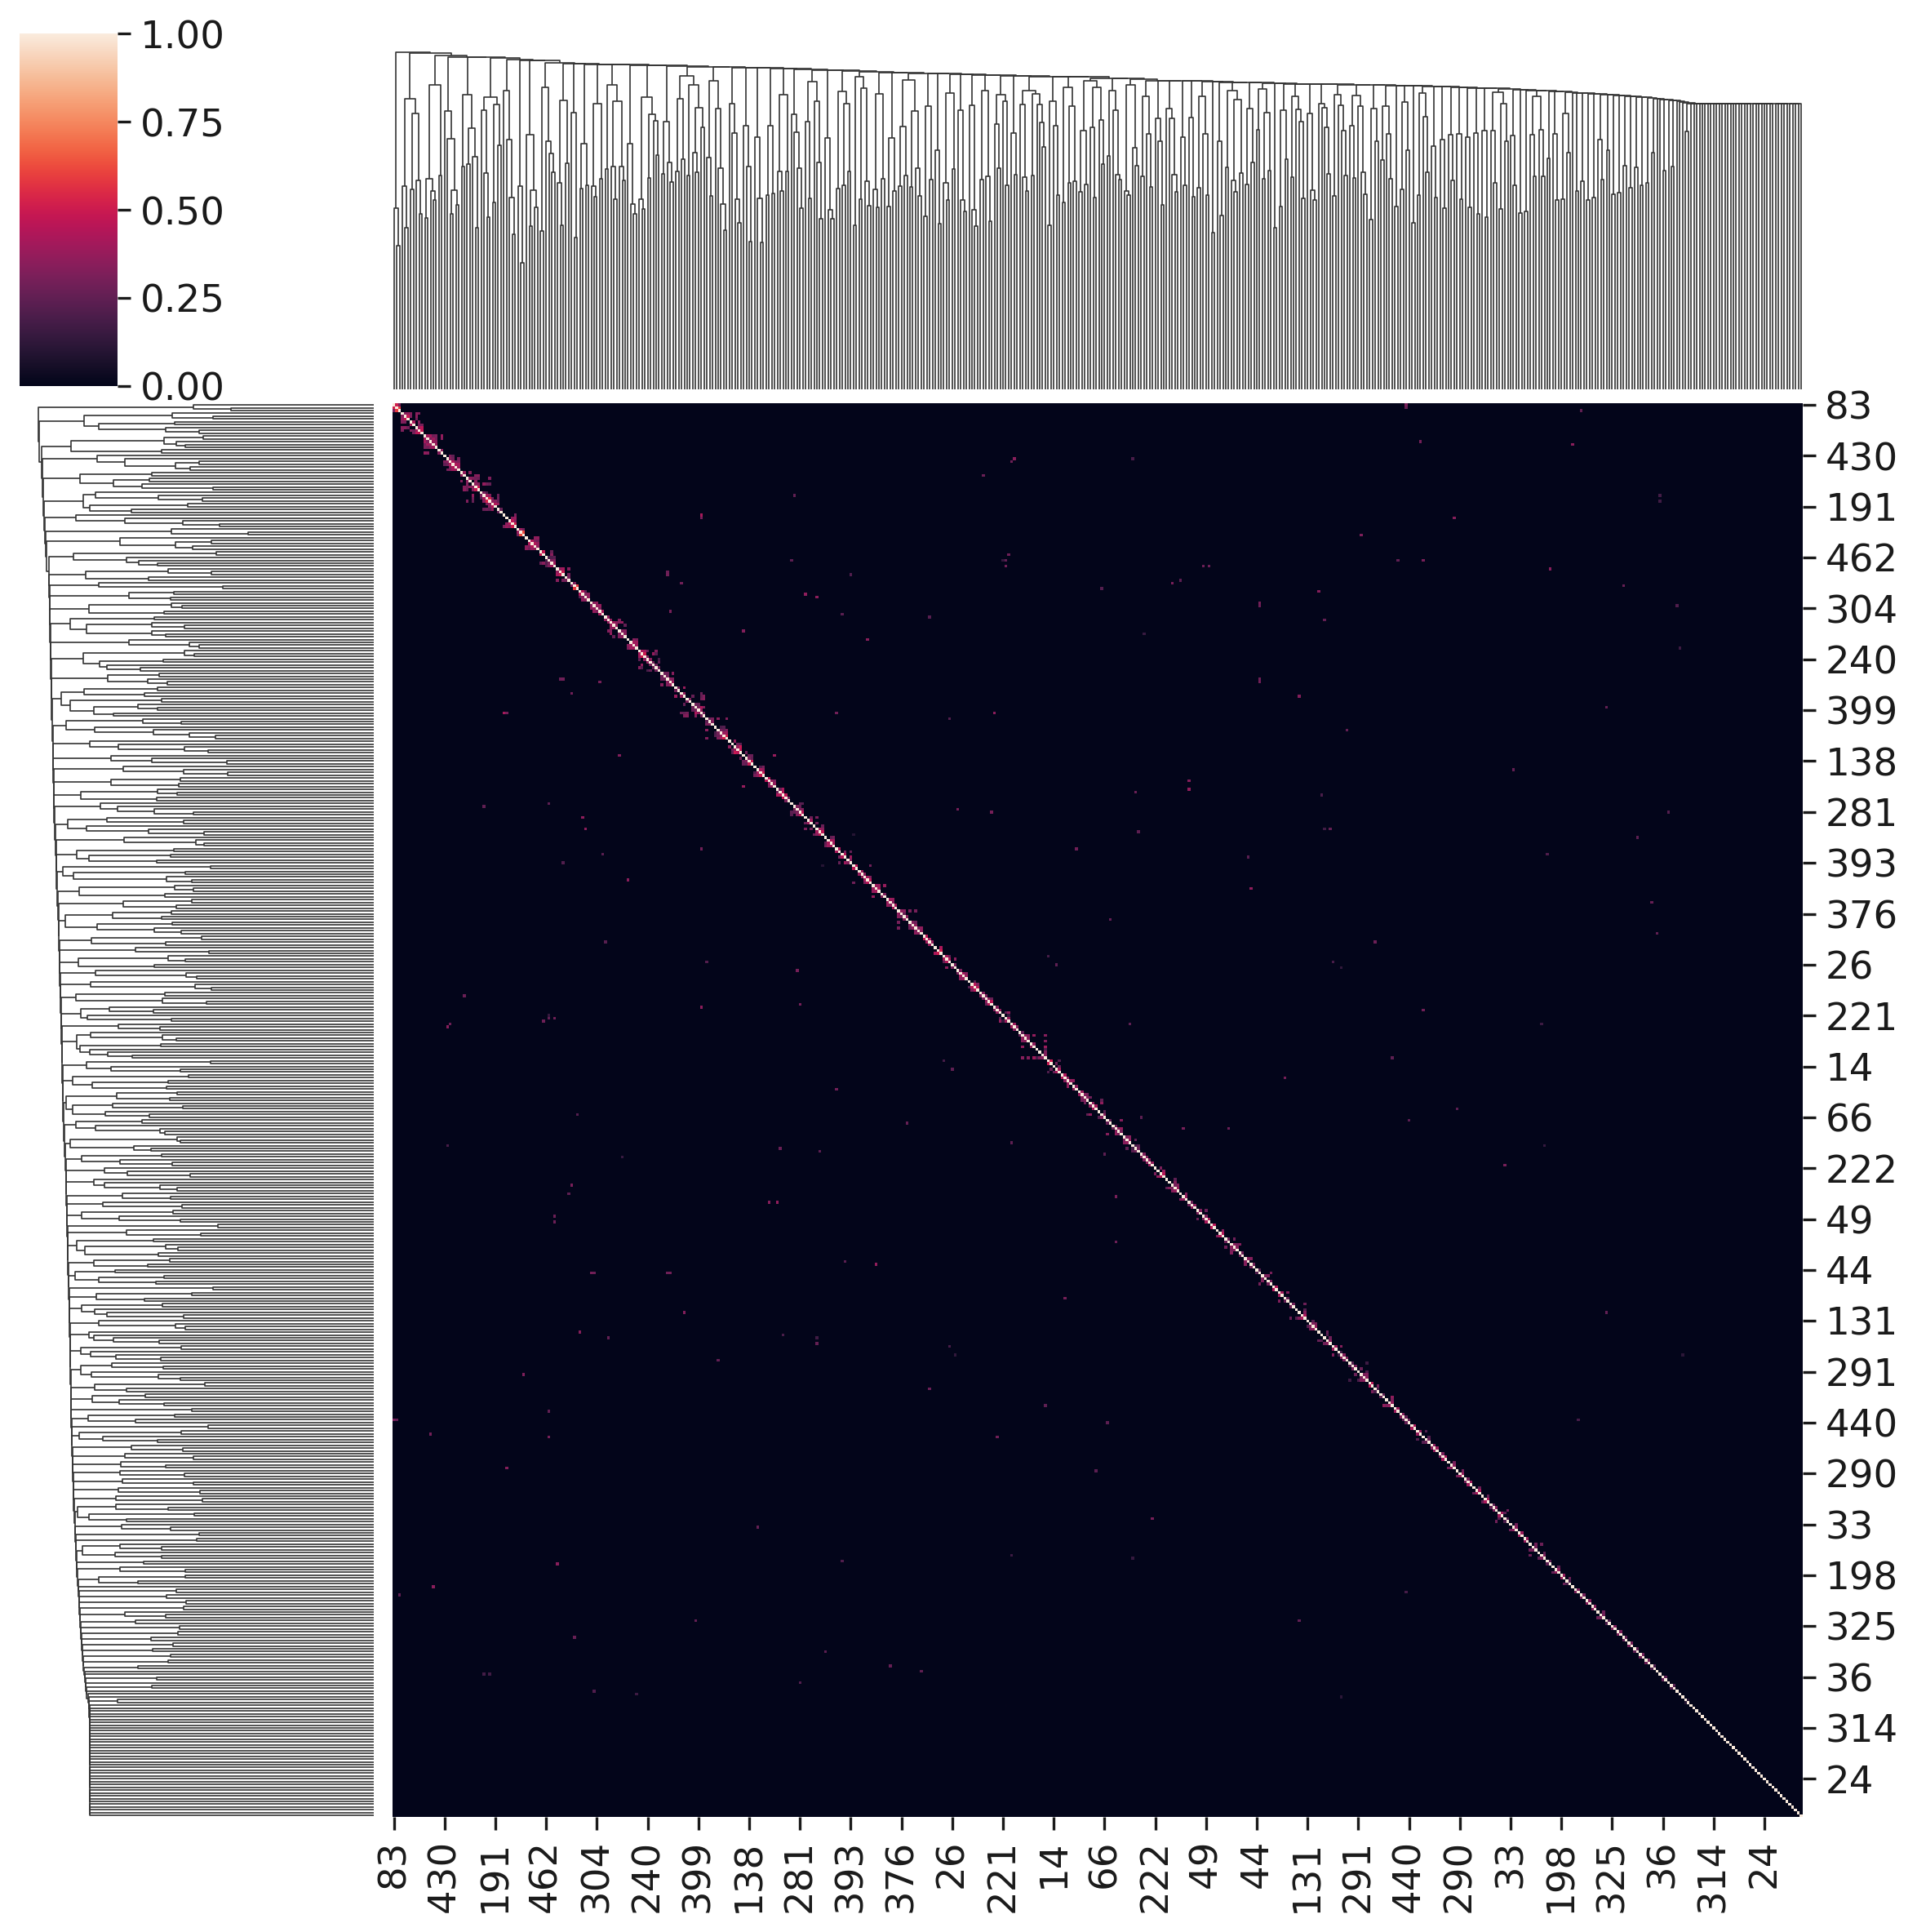

In [5]:
sns.clustermap(M.toarray()[:500,:500])

In [6]:
# Initialize archetypes
model.initialize_archetypes()

Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 48 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


  0%|          | 0/19 [00:00<?, ?it/s]

Selecting 9 cells from greedy initialization.


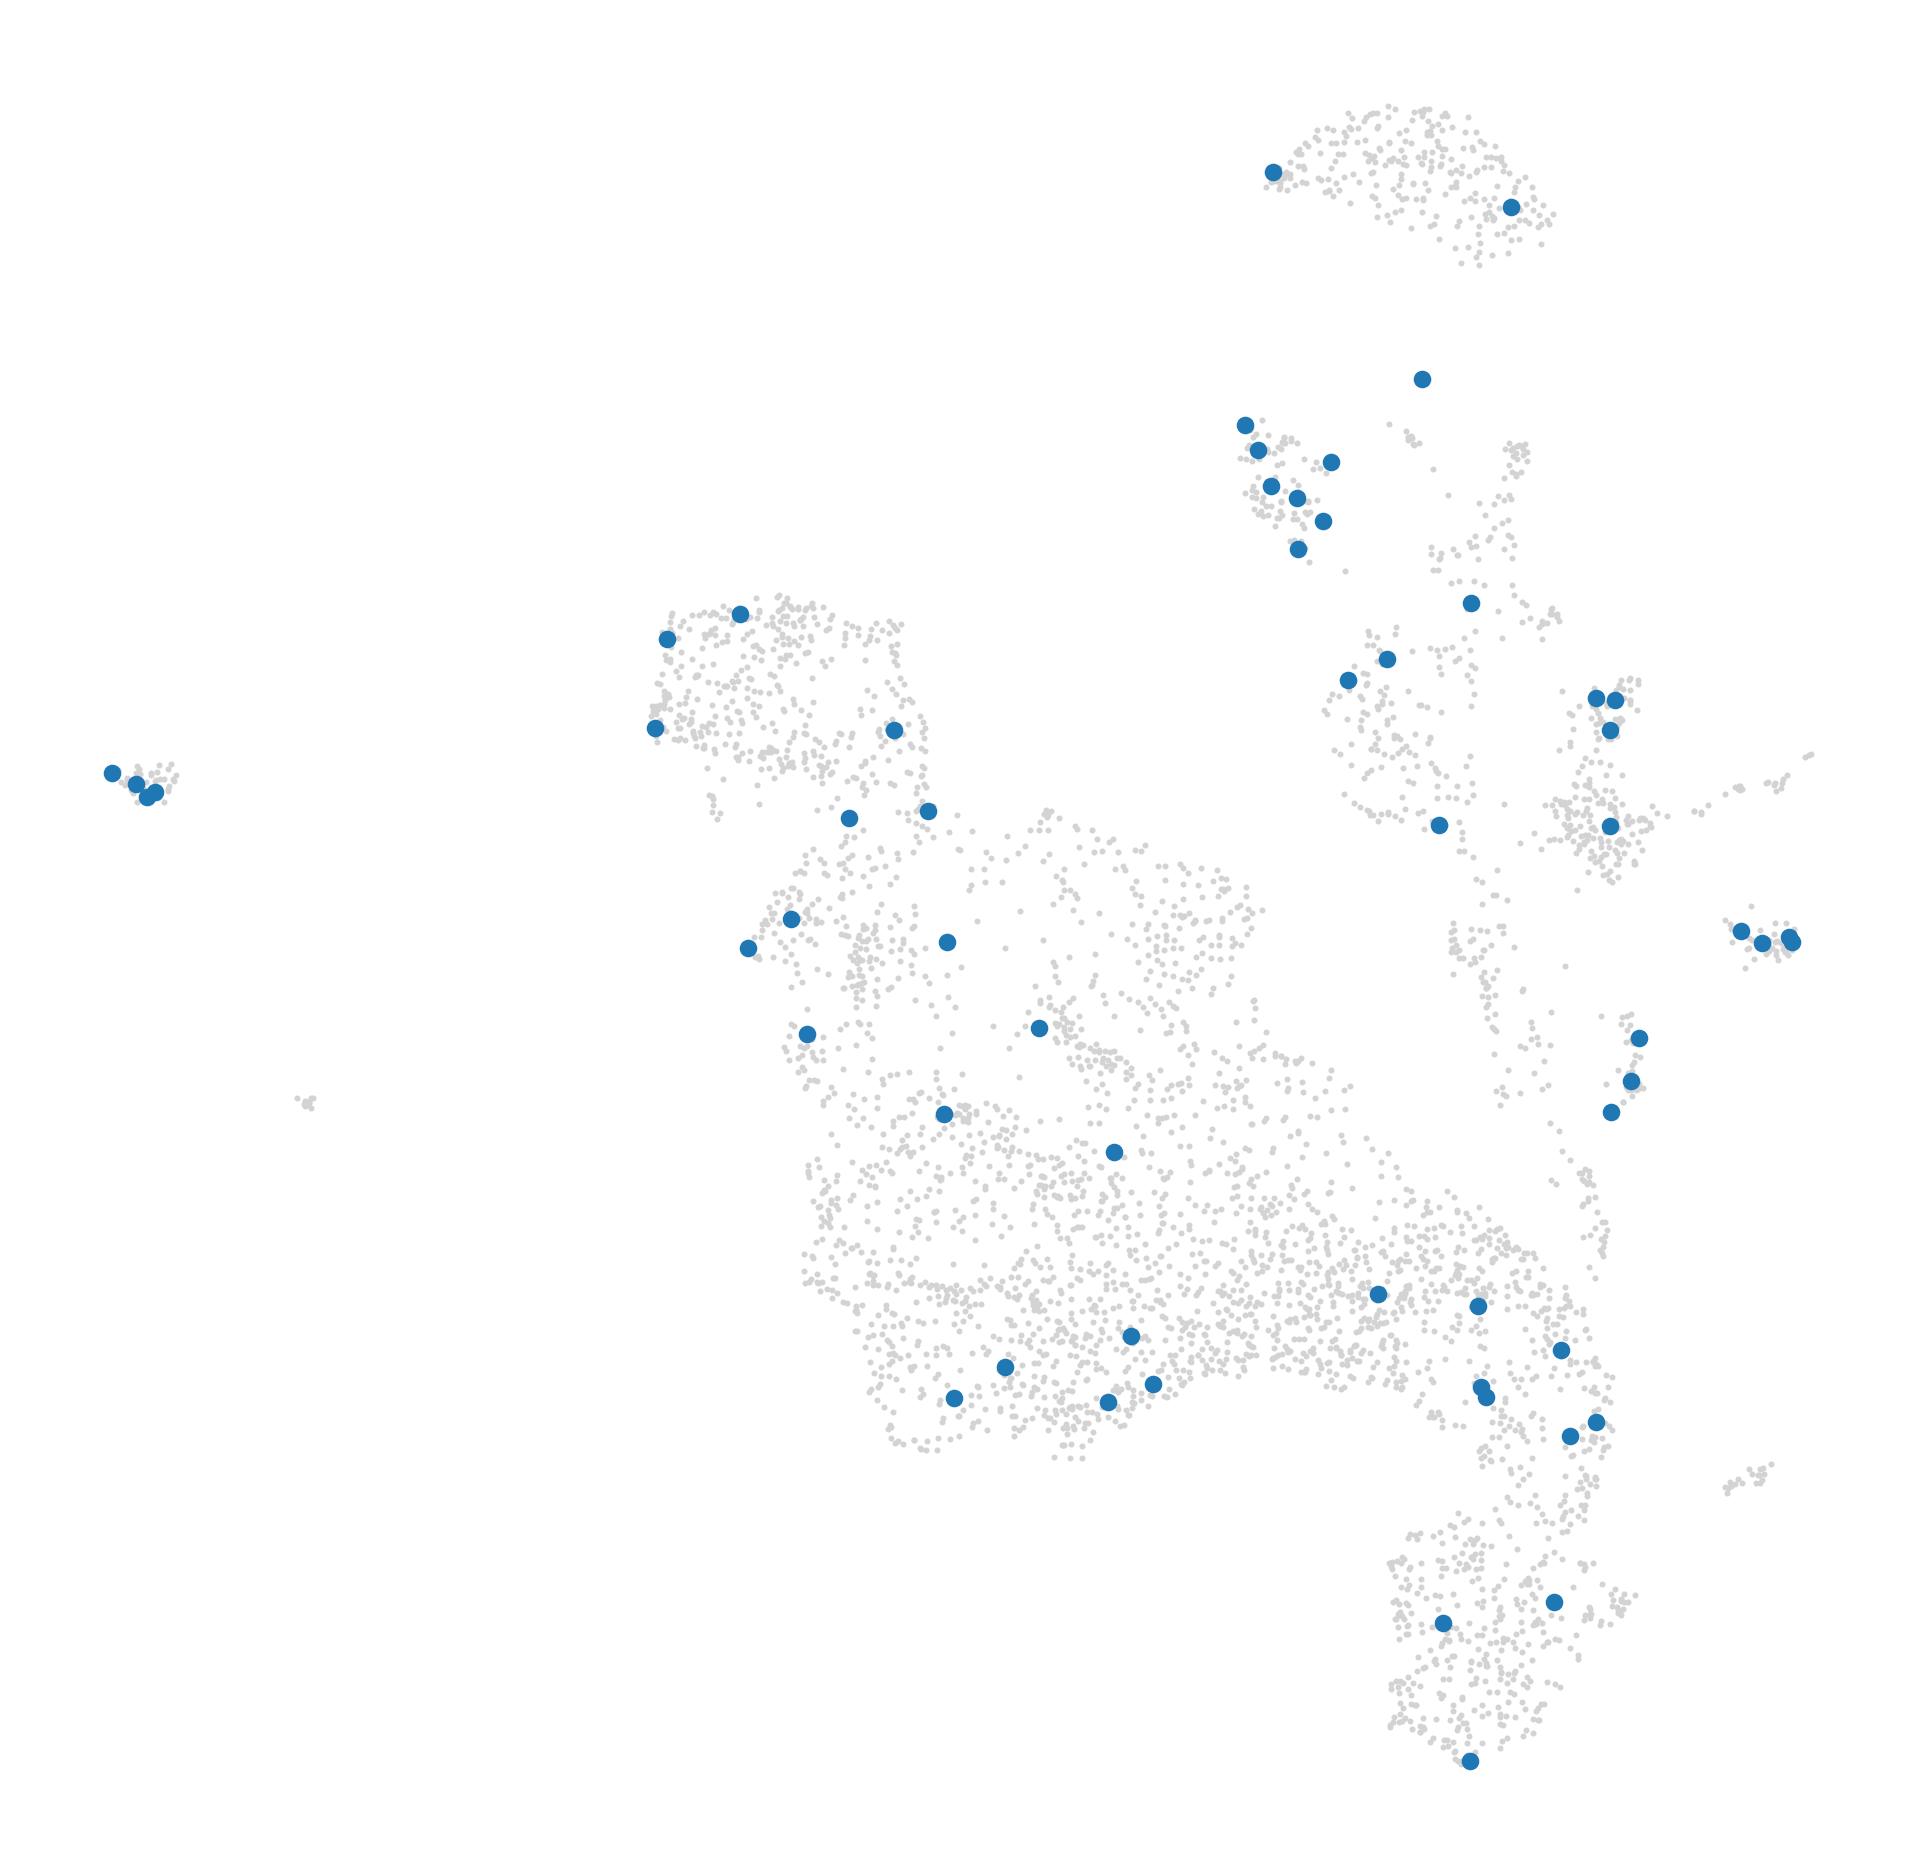

In [7]:
# Plot the initilization to ensure they are spread across phenotypic space
SEACells.plot.plot_initialization(rna, model)

In [8]:
model.fit(min_iter=10, max_iter=50)

# You can force the model to run additional iterations step-wise using the .step() function
print(f'Ran for {len(model.RSS_iters)} iterations')
for _ in range(5):
    model.step()
print(f'Ran for {len(model.RSS_iters)} iterations')

Randomly initialized A matrix.
Setting convergence threshold at 0.00115
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Converged after 34 iterations.
Ran for 35 iterations
Ran for 40 iterations


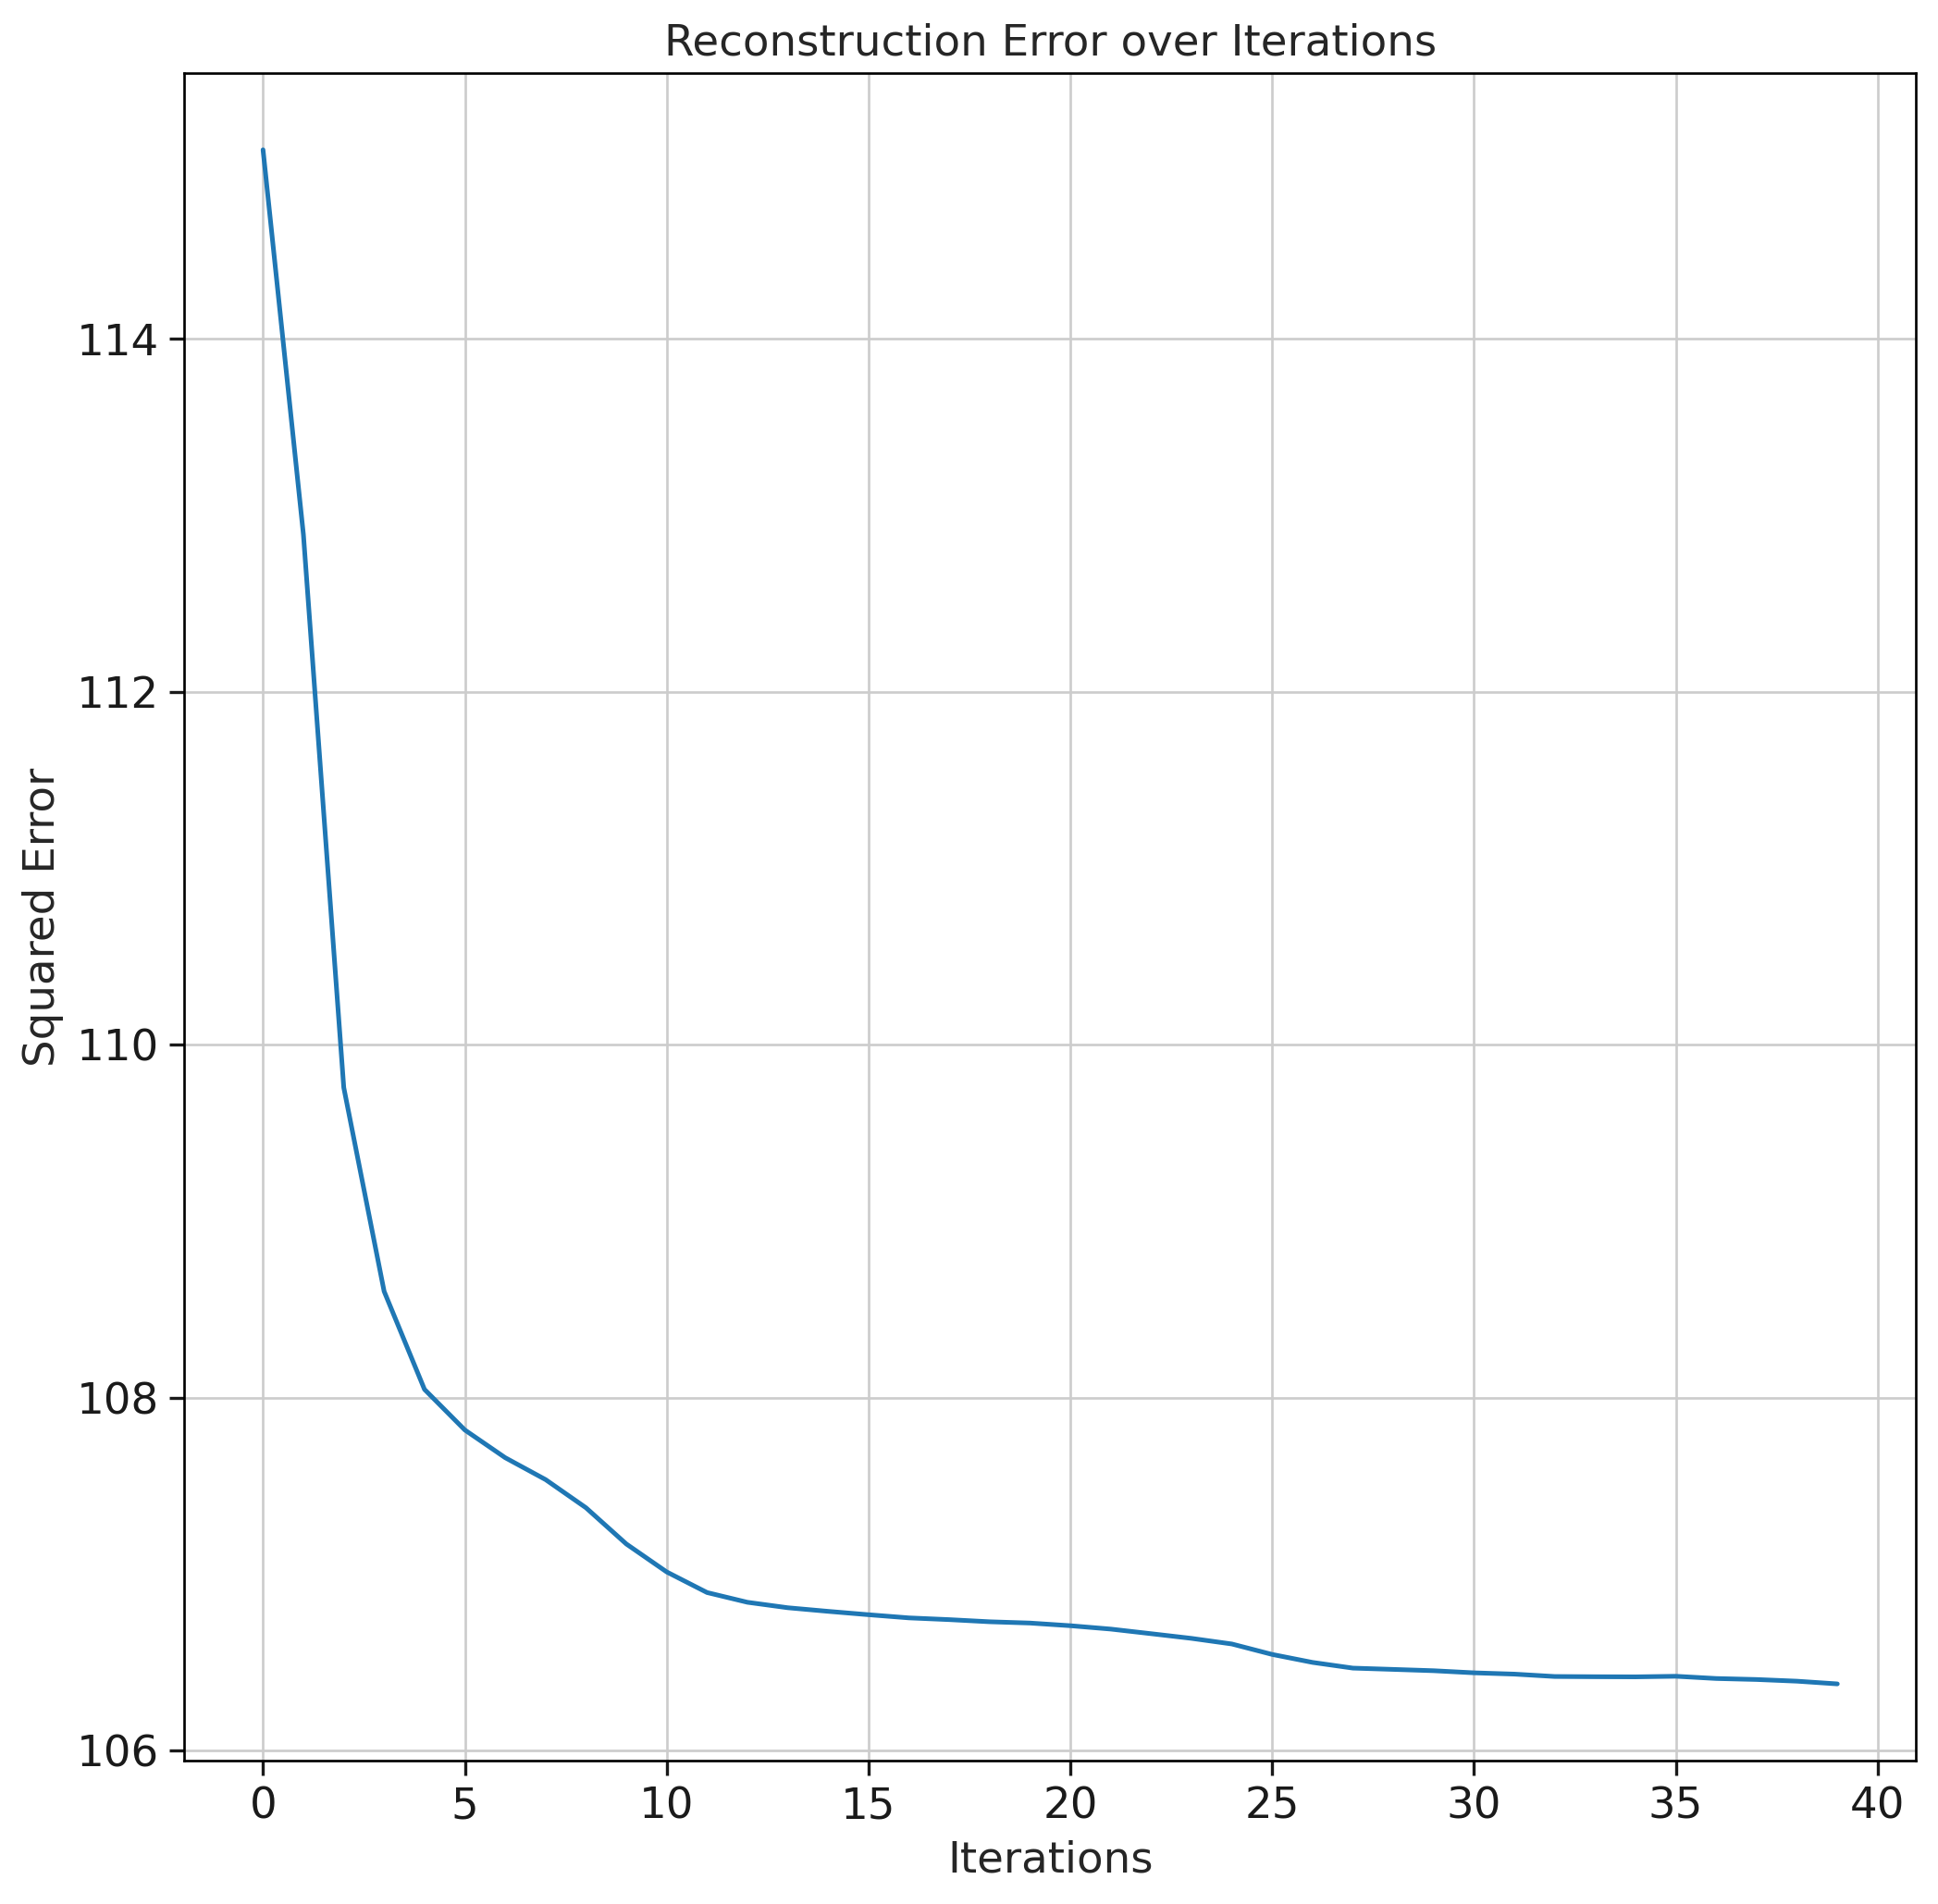

In [9]:
# Check for convergence 
model.plot_convergence()

In [10]:
SEACell_rna = SEACells.core.summarize_by_SEACell(rna, SEACells_label='SEACell', summarize_layer='raw')
SEACell_rna

  0%|          | 0/57 [00:00<?, ?it/s]

AnnData object with n_obs × n_vars = 57 × 32285
    layers: 'raw'

In [11]:
SEACell_soft_ad = SEACells.core.summarize_by_soft_SEACell(rna, model.A_, celltype_label='leiden',summarize_layer='raw', minimum_weight=0.05)
SEACell_soft_ad

  0%|          | 0/57 [00:00<?, ?it/s]

AnnData object with n_obs × n_vars = 57 × 32285
    obs: 'Pseudo-sizes', 'celltype', 'celltype_purity'

/home/ak431480/.conda/envs/seacells/lib/python3.8/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/ak431480/.conda/envs/seacells/lib/python3.8/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


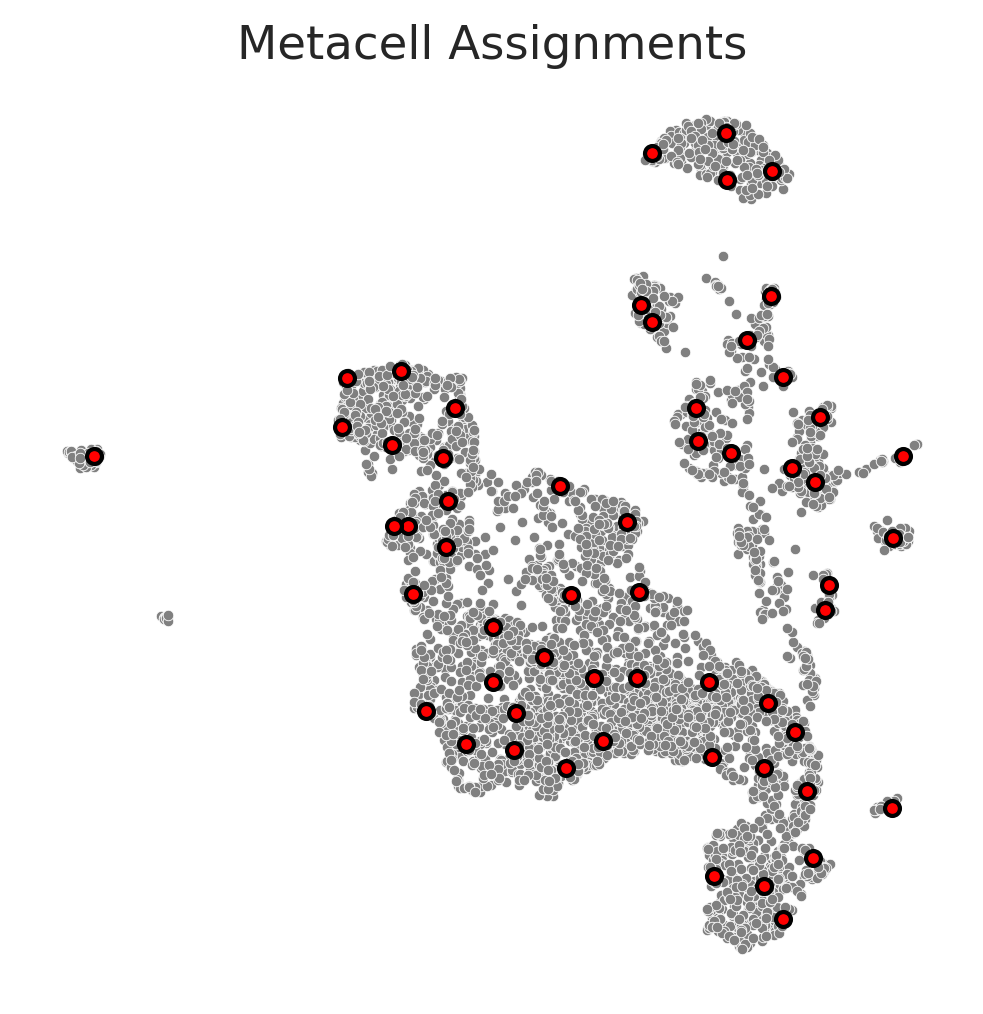

In [12]:
SEACells.plot.plot_2D(rna, key='X_umap', colour_metacells=False)

/home/ak431480/.conda/envs/seacells/lib/python3.8/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/ak431480/.conda/envs/seacells/lib/python3.8/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


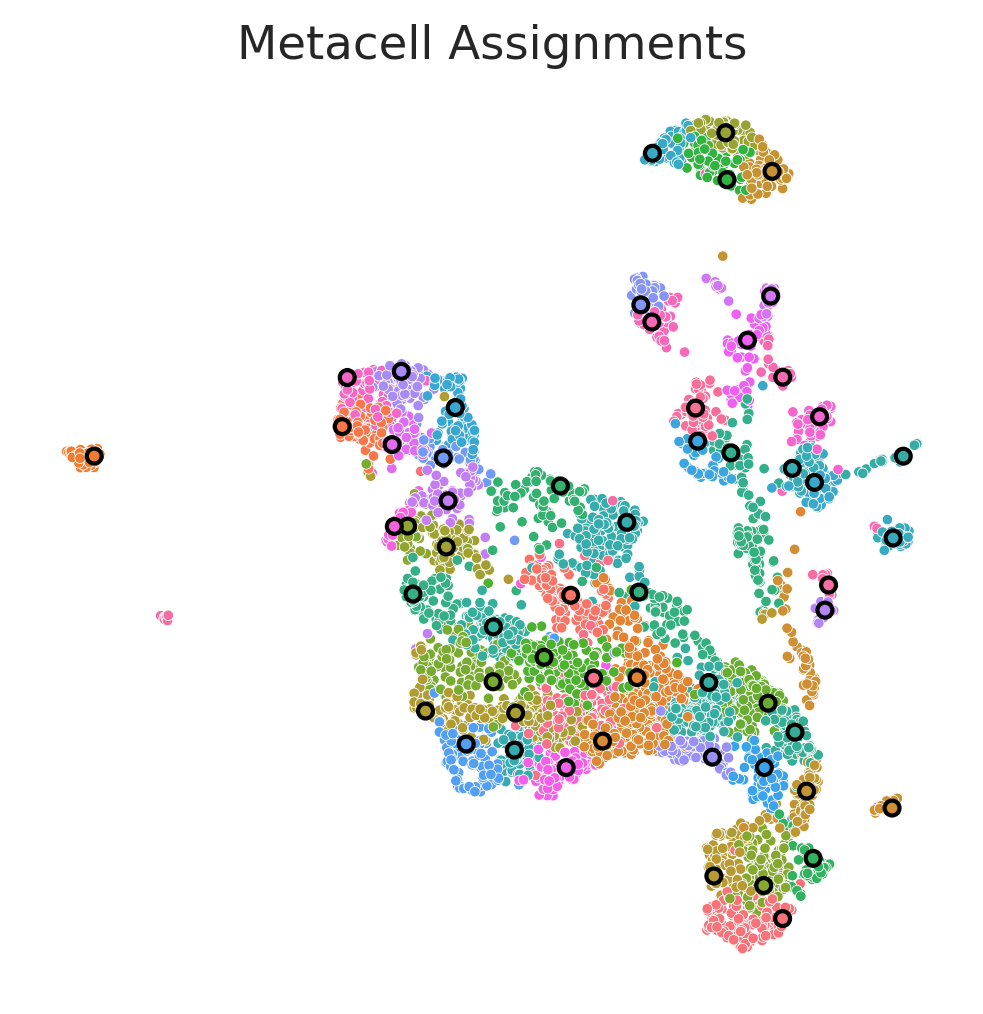

In [13]:
SEACells.plot.plot_2D(rna, key='X_umap', colour_metacells=True)

/home/ak431480/.conda/envs/seacells/lib/python3.8/site-packages/SEACells/plot.py:120: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(label_df.groupby('SEACell').count().iloc[:, 0], bins=bins)


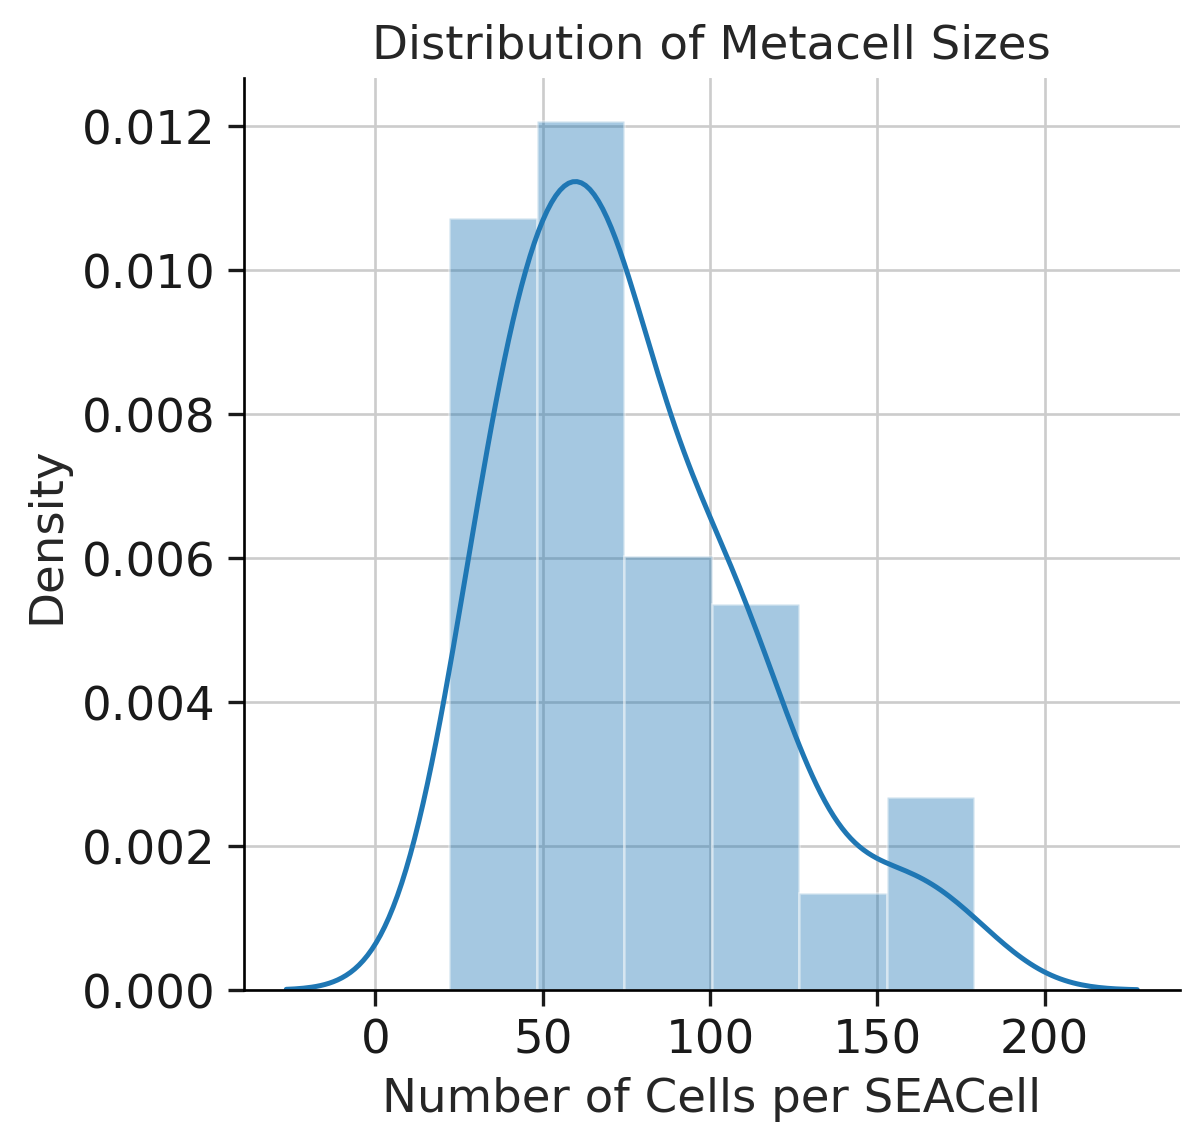

,size
SEACell,
AAAGCAAGTTGCTGGG-1,108
ACACTTAAGGTCATTA-1,61
ACAGTATGTTGGATAT-1,92
ACCTACCTCACGAATC-1,67
AGCAAGGGTGGCTTCC-1,70
AGTGTGGCAGGATTAA-1,101
ATGTAACGTAATCACG-1,74
CAAACACTCACTTCAT-1,179
CAAGGTTTCTTTGAGA-1,93


In [14]:
SEACells.plot.plot_SEACell_sizes(rna, bins=6)

# rna[rna.obs['SEACell'].value_counts()[:10].index].obs['leiden'].value_counts()

Determing nearest neighbor graph...


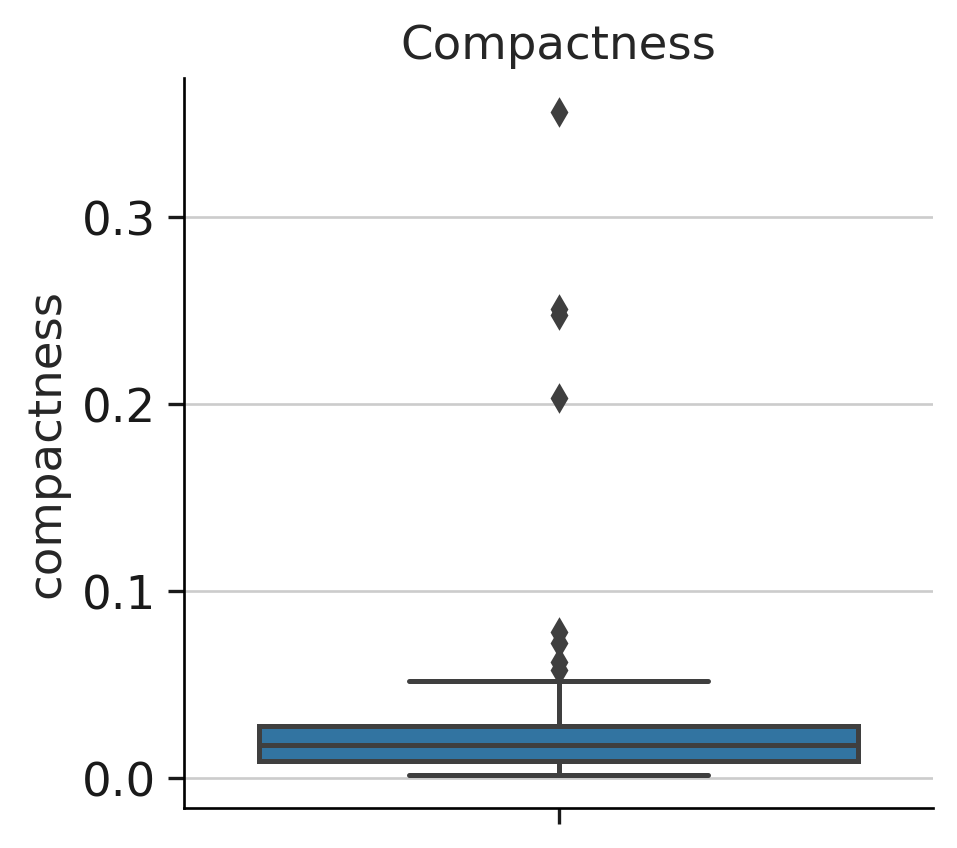

,compactness
SEACell,
AAAGCAAGTTGCTGGG-1,0.009012
ACACTTAAGGTCATTA-1,0.017371
ACAGTATGTTGGATAT-1,0.007904
ACCTACCTCACGAATC-1,0.023424
AGCAAGGGTGGCTTCC-1,0.009327


In [15]:
compactness = SEACells.evaluate.compactness(rna, 'X_pca')

plt.figure(figsize=(4,4))
sns.boxplot(data=compactness, y='compactness')
plt.title('Compactness')
sns.despine()
plt.show()
plt.close()

compactness.head()

In [16]:
rna.obs[rna.obs.index == compactness.sort_values(['compactness'],ascending=False).iloc[0].name]

,n_counts,leiden,SEACell
index,,,
GGCTGGTTCTTAGGAC-1,14742.0,20,GGCTGGTTCTTAGGAC-1


Determing nearest neighbor graph...


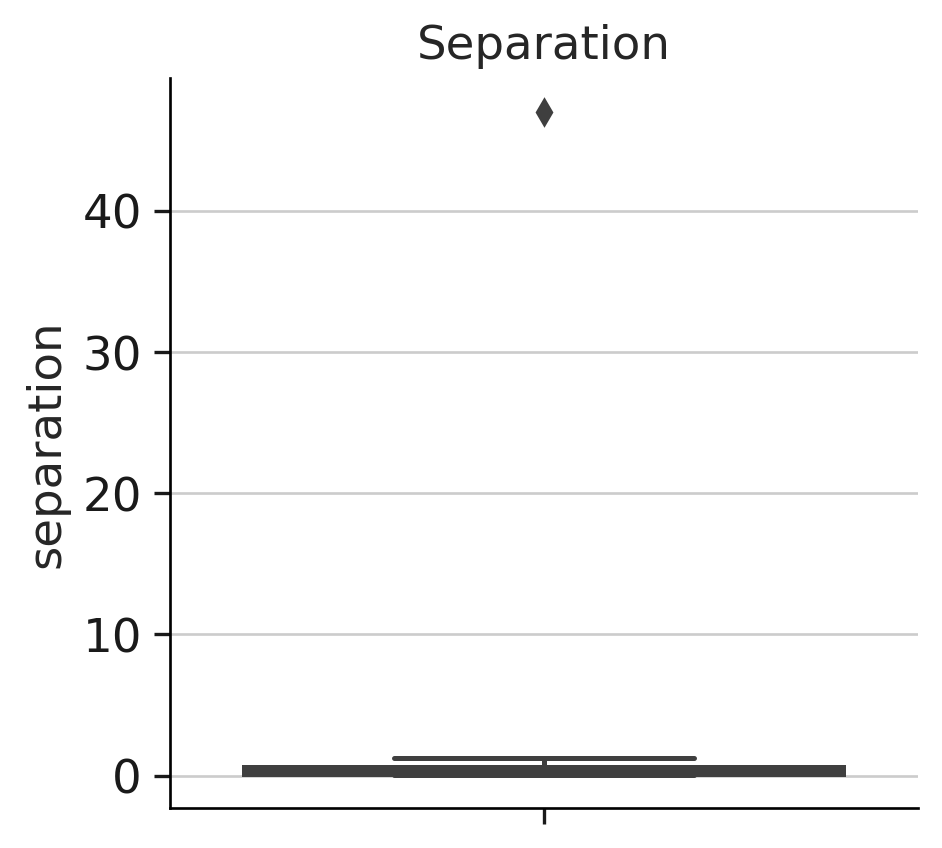

,separation
SEACell,
AAAGCAAGTTGCTGGG-1,0.430445
ACACTTAAGGTCATTA-1,0.111747
ACAGTATGTTGGATAT-1,0.183600
ACCTACCTCACGAATC-1,0.158386
AGCAAGGGTGGCTTCC-1,0.163353


In [17]:
separation = SEACells.evaluate.separation(rna, 'X_pca',nth_nbr=1)
plt.figure(figsize=(4,4))
sns.boxplot(data=separation, y='separation')
plt.title('Separation')
sns.despine()
plt.show()
plt.close()

separation.head()

### Run SEACells on ATAC

In [22]:
## User defined parameters

## Core parameters 
n_SEACells = int(len(atac)/75)
build_kernel_on = 'X_svd' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells

model = SEACells.core.SEACells(atac, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

In [23]:
model.construct_kernel_matrix()
M = model.kernel_matrix

Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/4349 [00:00<?, ?it/s]

Making graph symmetric...
Computing RBF kernel...


  0%|          | 0/4349 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/4349 [00:00<?, ?it/s]

Constructing CSR matrix...


/home/ak431480/.conda/envs/seacells/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


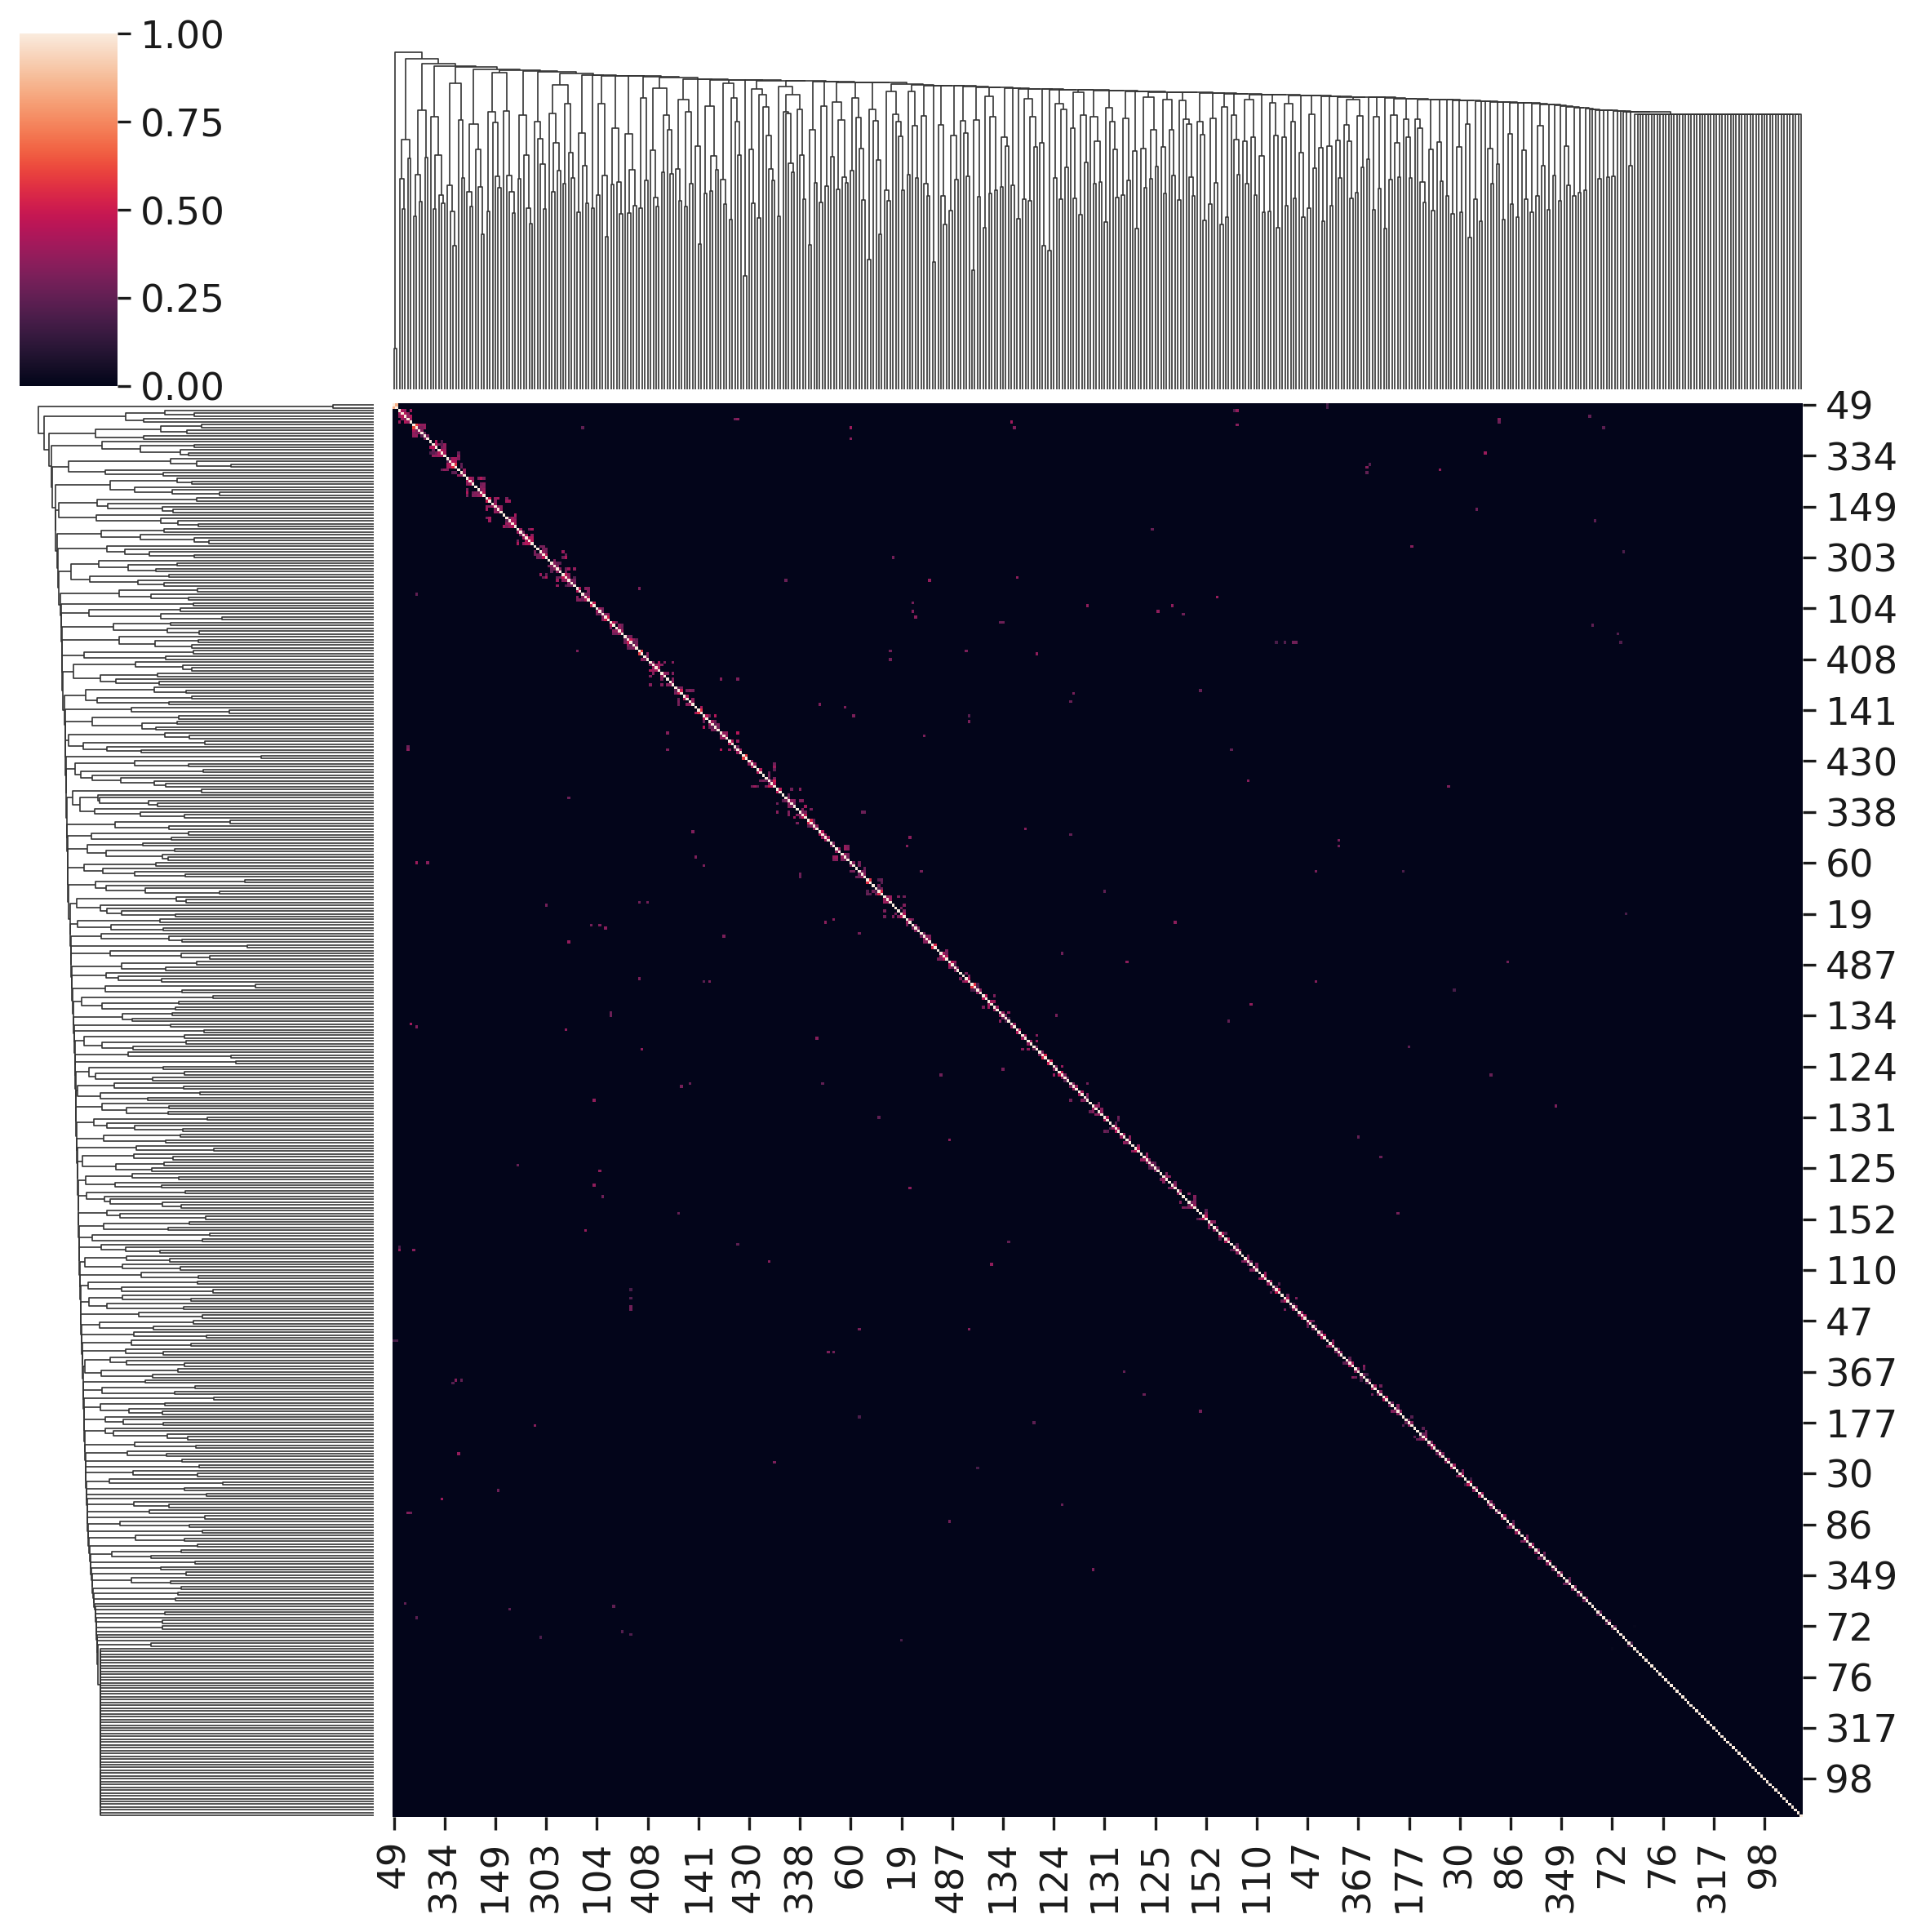

In [24]:
sns.clustermap(M.toarray()[:500,:500])

In [25]:
# Initialize archetypes
model.initialize_archetypes()

Building kernel on X_svd
Computing diffusion components from X_svd for waypoint initialization ... 
Determing nearest neighbor graph...


/home/ak431480/.conda/envs/seacells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)


Done.
Sampling waypoints ...
Done.
Selecting 49 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


  0%|          | 0/18 [00:00<?, ?it/s]

Selecting 8 cells from greedy initialization.


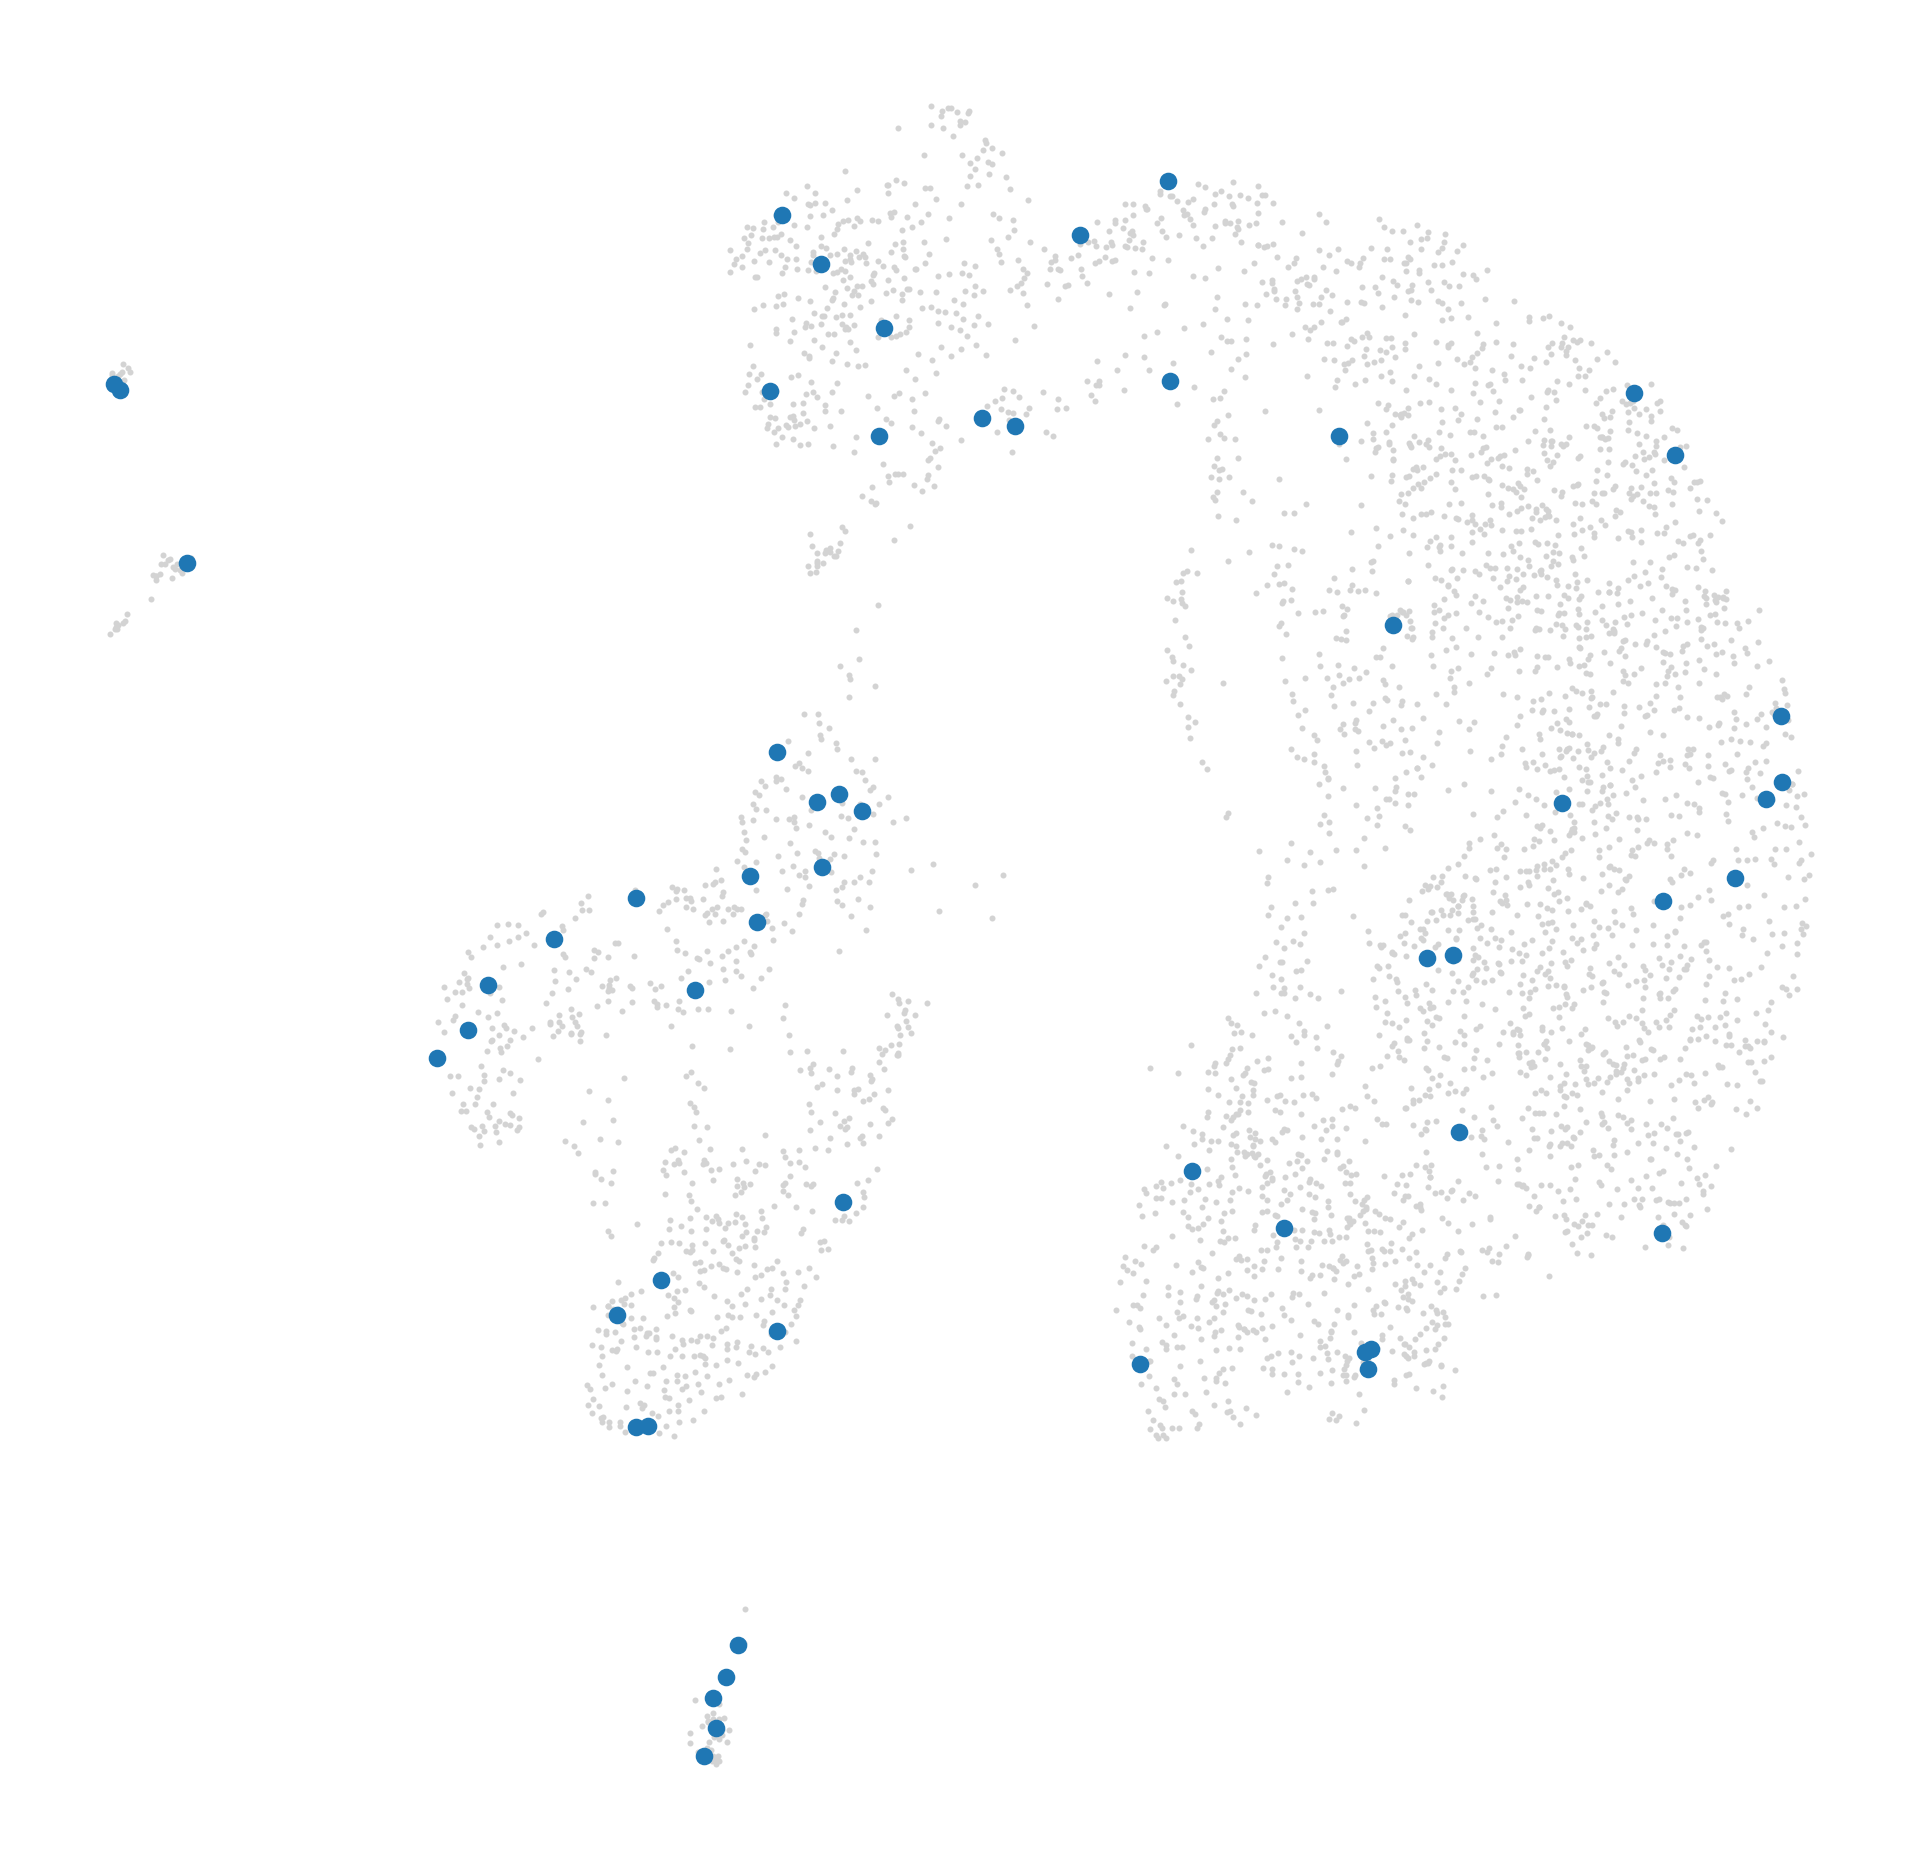

In [26]:
# Plot the initilization to ensure they are spread across phenotypic space
SEACells.plot.plot_initialization(atac, model)

In [27]:
model.fit(min_iter=10, max_iter=50)

Randomly initialized A matrix.
Setting convergence threshold at 0.00117
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 24 iterations.


Ran for 25 iterations
Ran for 30 iterations


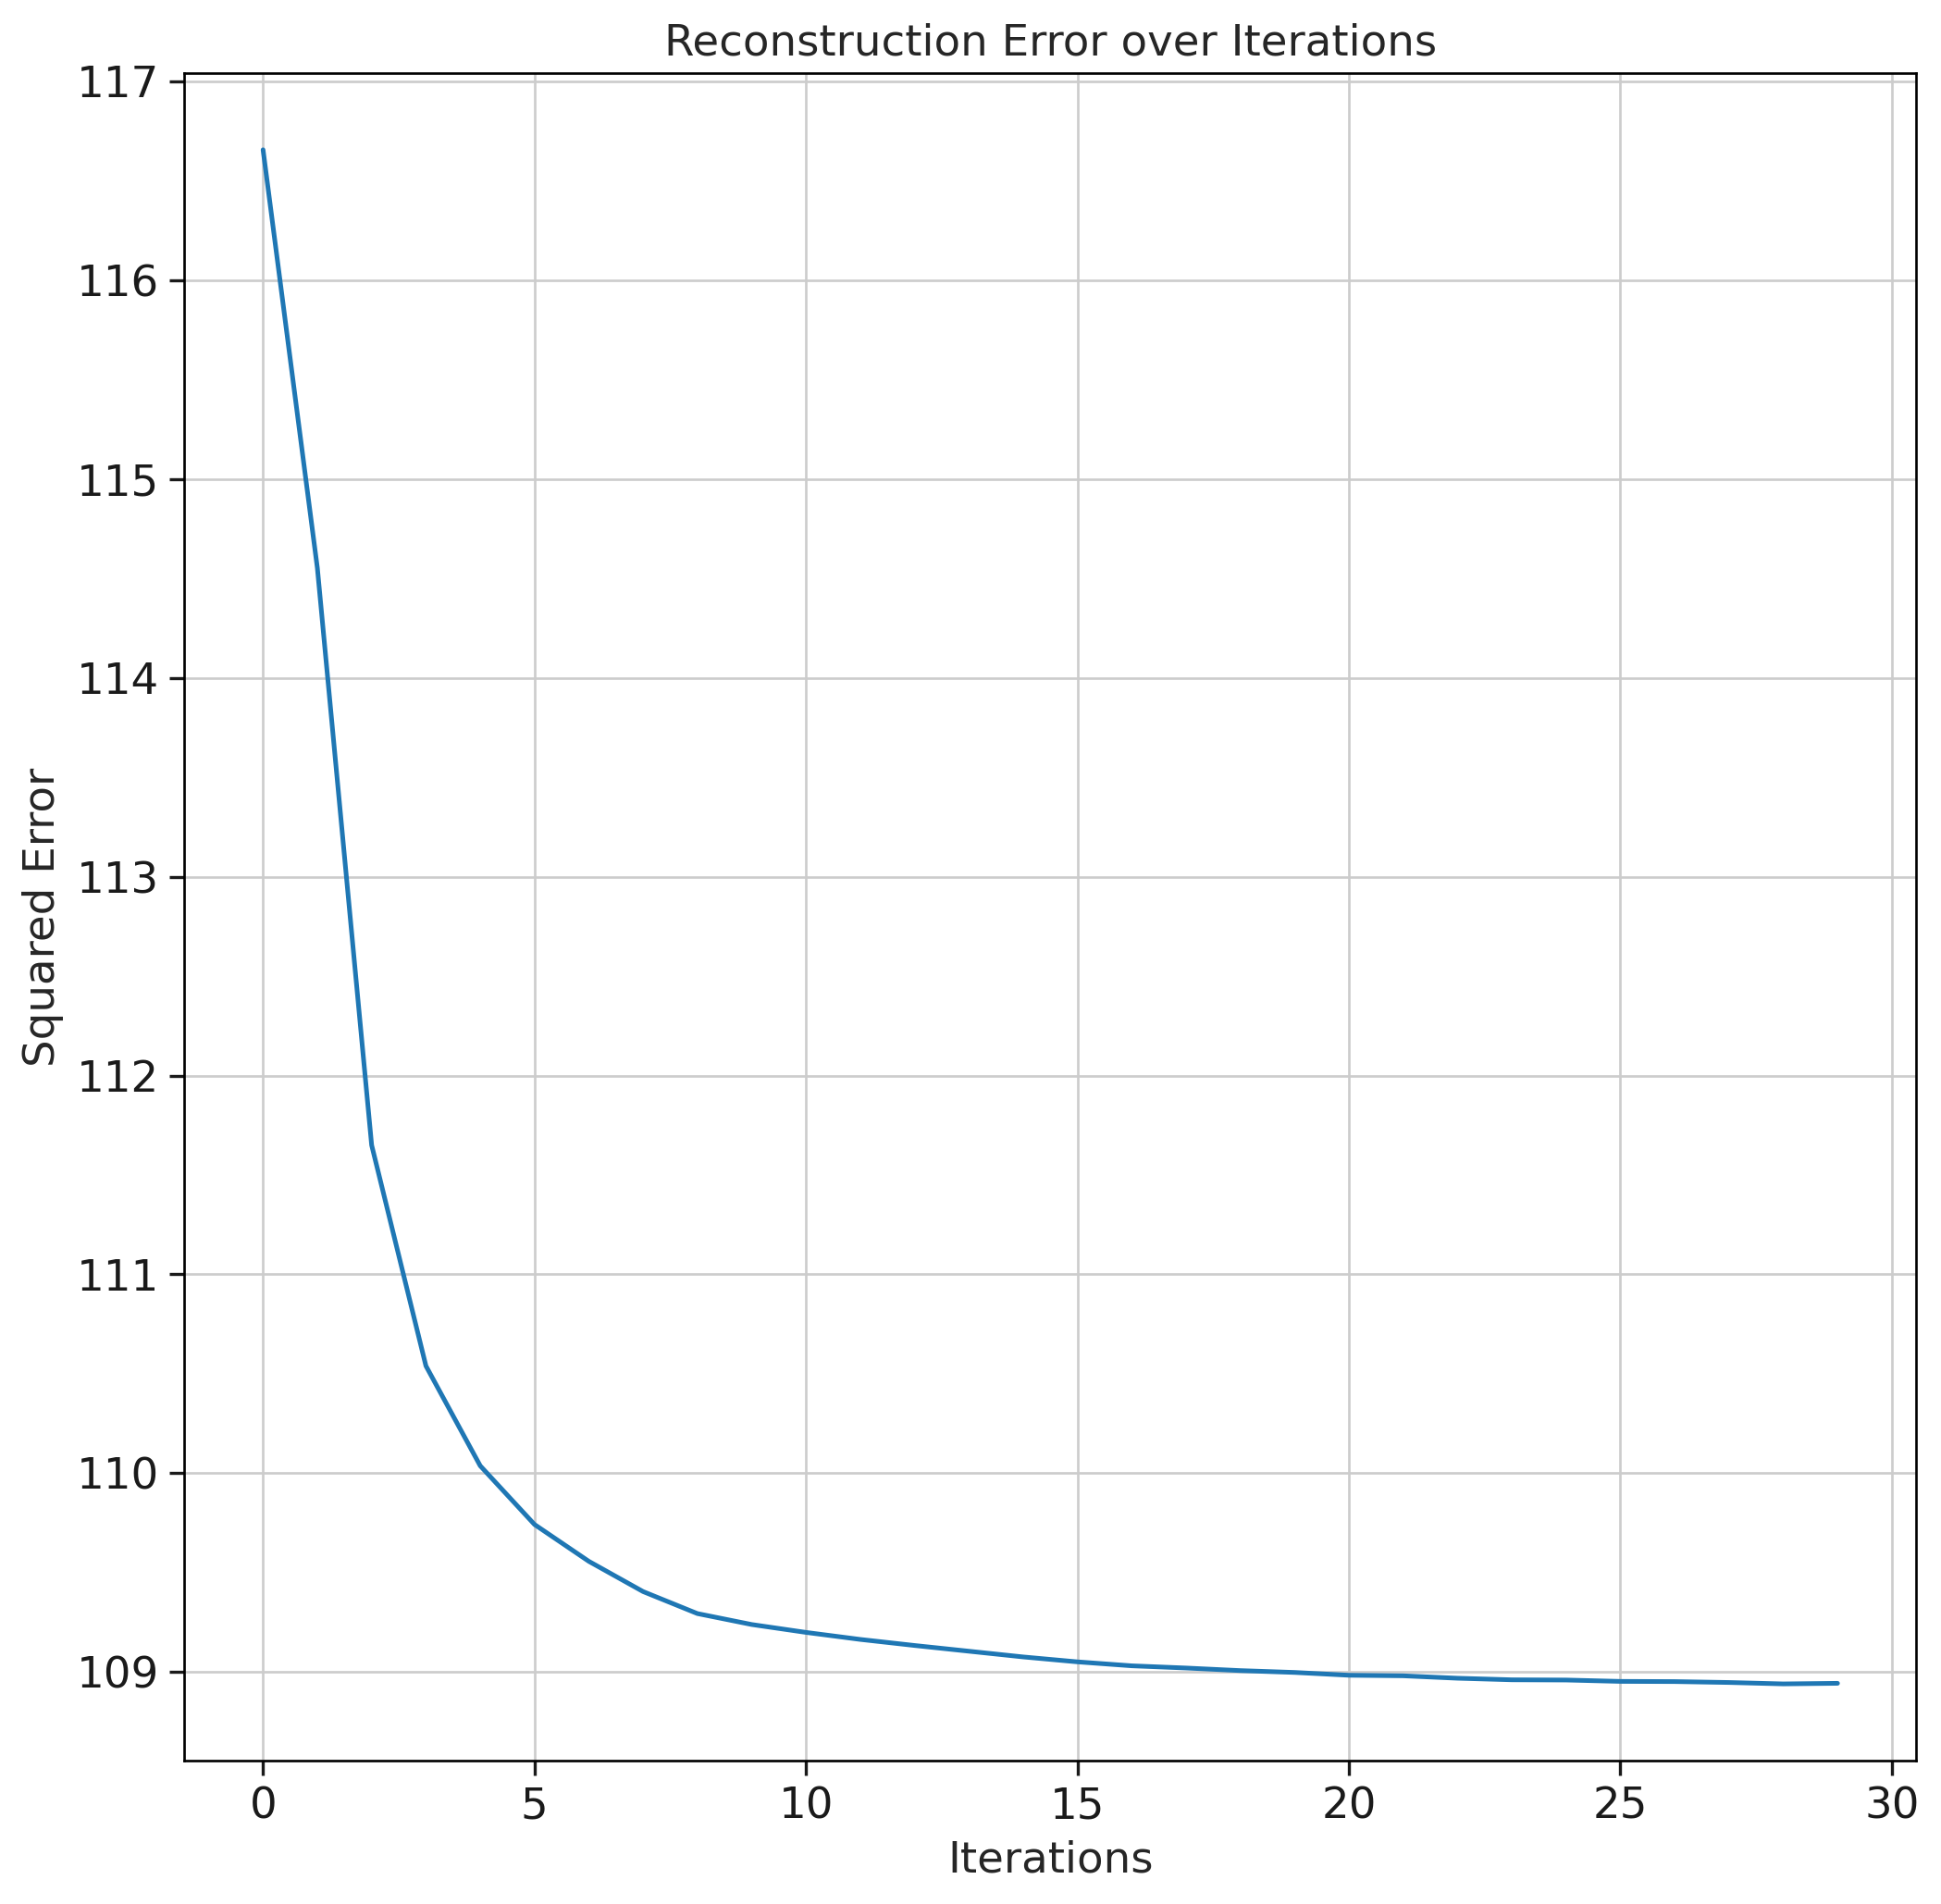

In [28]:
# You can force the model to run additional iterations step-wise using the .step() function
print(f'Ran for {len(model.RSS_iters)} iterations')
for _ in range(5):
    model.step()
print(f'Ran for {len(model.RSS_iters)} iterations')

# Check for convergence 
model.plot_convergence()

In [29]:
SEACell_atac = SEACells.core.summarize_by_SEACell(atac, SEACells_label='SEACell', summarize_layer='raw')
SEACell_atac

  0%|          | 0/57 [00:00<?, ?it/s]

AnnData object with n_obs × n_vars = 57 × 122247
    layers: 'raw'

In [30]:
SEACell_soft_ad = SEACells.core.summarize_by_soft_SEACell(atac, model.A_, celltype_label='leiden',summarize_layer='raw', minimum_weight=0.05)
SEACell_soft_ad

  0%|          | 0/57 [00:00<?, ?it/s]

AnnData object with n_obs × n_vars = 57 × 122247
    obs: 'Pseudo-sizes', 'celltype', 'celltype_purity'

/home/ak431480/.conda/envs/seacells/lib/python3.8/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/ak431480/.conda/envs/seacells/lib/python3.8/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


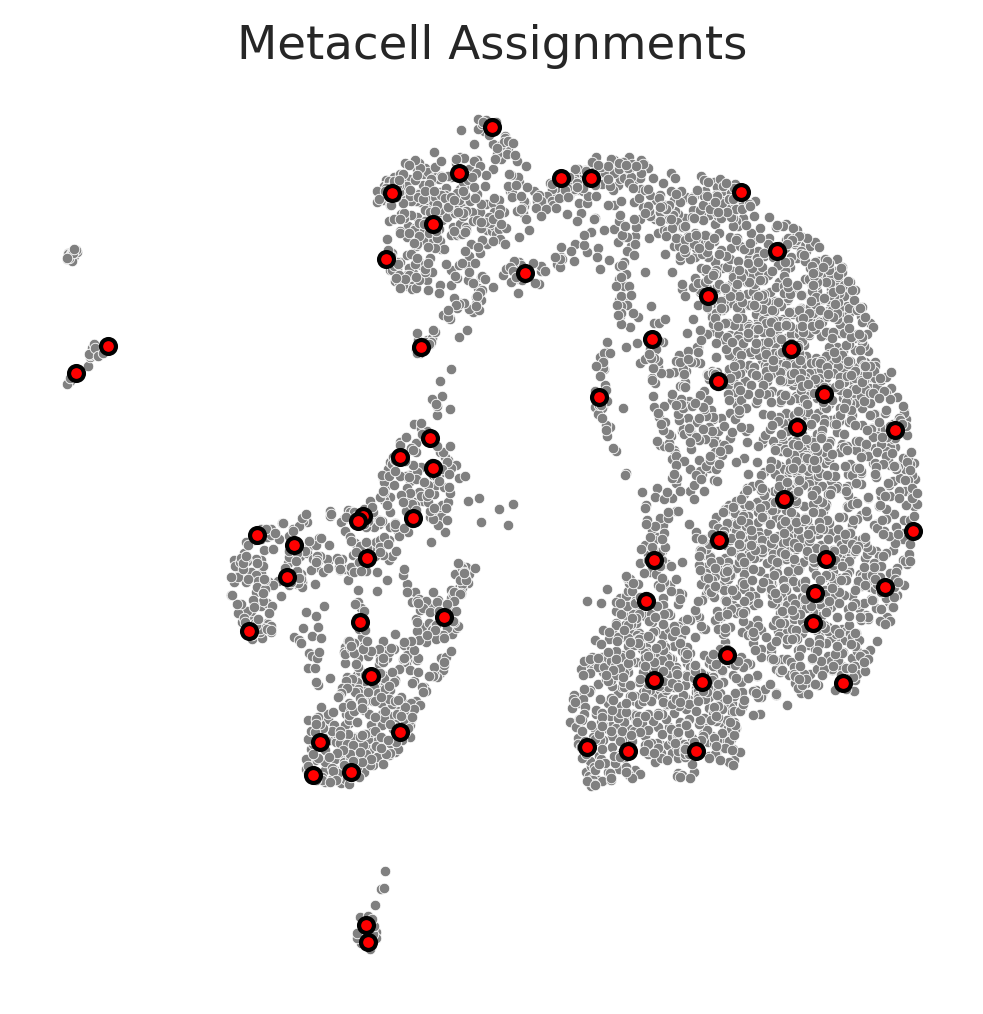

In [31]:
SEACells.plot.plot_2D(atac, key='X_umap', colour_metacells=False)

/home/ak431480/.conda/envs/seacells/lib/python3.8/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/ak431480/.conda/envs/seacells/lib/python3.8/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


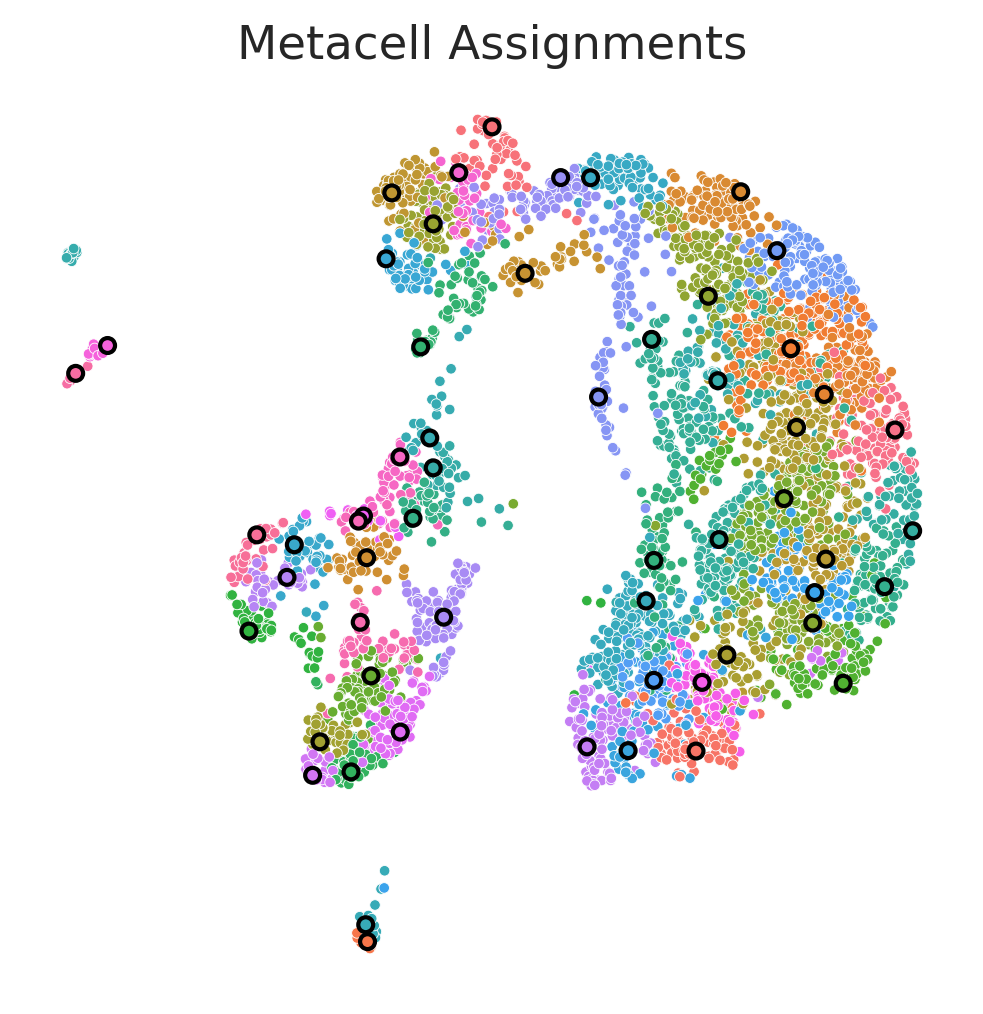

In [32]:
SEACells.plot.plot_2D(atac, key='X_umap', colour_metacells=True)

/home/ak431480/.conda/envs/seacells/lib/python3.8/site-packages/SEACells/plot.py:120: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(label_df.groupby('SEACell').count().iloc[:, 0], bins=bins)


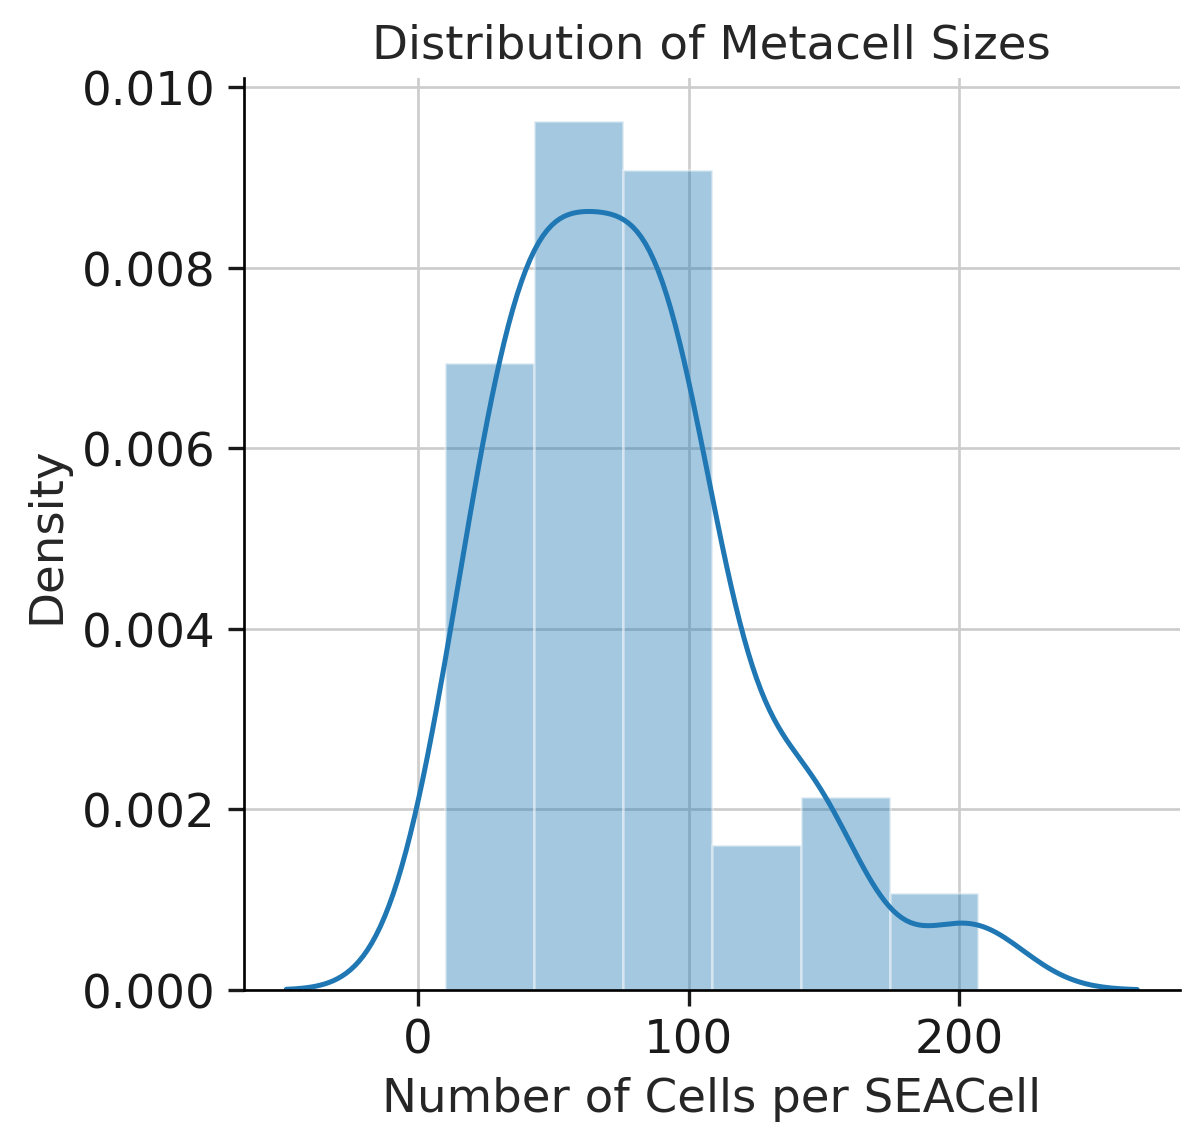

,size
SEACell,
AACATTGTCGATTCTT-1,29
AAGAACAGTCATAACG-1,50
AATGCGCGTTACGCGG-1,101
AATGGCGCAGGCTAGA-1,149
ACCAAGCGTGCCGCAA-1,90
ACCCGGTAGCTTACTT-1,26
ACCTTCCAGCTAATCA-1,207
ACGAAGTCACCCACCT-1,88
AGCCTGGGTCTAGCTT-1,56


In [33]:
SEACells.plot.plot_SEACell_sizes(atac, bins=6)

### ATAC & RNA JOINT SEACELL LABELS

In [35]:
atac_meta_ad, rna_meta_ad = SEACells.genescores.prepare_multiome_anndata(atac, rna, SEACell_label='SEACell')

Generating Metacell matrices...
 ATAC


100%|███████████████████████████████████████████████████████████████| 57/57 [00:02<00:00, 26.17it/s]
/home/ak431480/.conda/envs/seacells/lib/python3.8/site-packages/SEACells/genescores.py:59: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  atac_meta_ad = sc.AnnData(summ_matrix)
/home/ak431480/.conda/envs/seacells/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell
/home/ak431480/.conda/envs/seacells/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


 RNA


/home/ak431480/.conda/envs/seacells/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
100%|██████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 159.33it/s]
/home/ak431480/.conda/envs/seacells/lib/python3.8/site-packages/SEACells/genescores.py:80: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  rna_meta_ad = sc.AnnData(summ_matrix)
/home/ak431480/.conda/envs/seacells/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [36]:
if all(rna_meta_ad.obs.sort_index().index == atac_meta_ad.obs.sort_index().index):
    rna.write('../data/seacells-rna-multiome10x-mouse.h5ad')
    atac.write('../data/seacells-atac-multiome10x-mouse.h5ad')

In [38]:
if all(rna_meta_ad.obs.sort_index().index == atac_meta_ad.obs.sort_index().index):
    atac_meta_ad.write('../data/seacell-meta-atac-multiome10x-mouse.h5ad')
    rna_meta_ad.write('../data/seacell-meta-rna-multiome10x-mouse.h5ad')